## <center>Выжившие на Титанике</center>

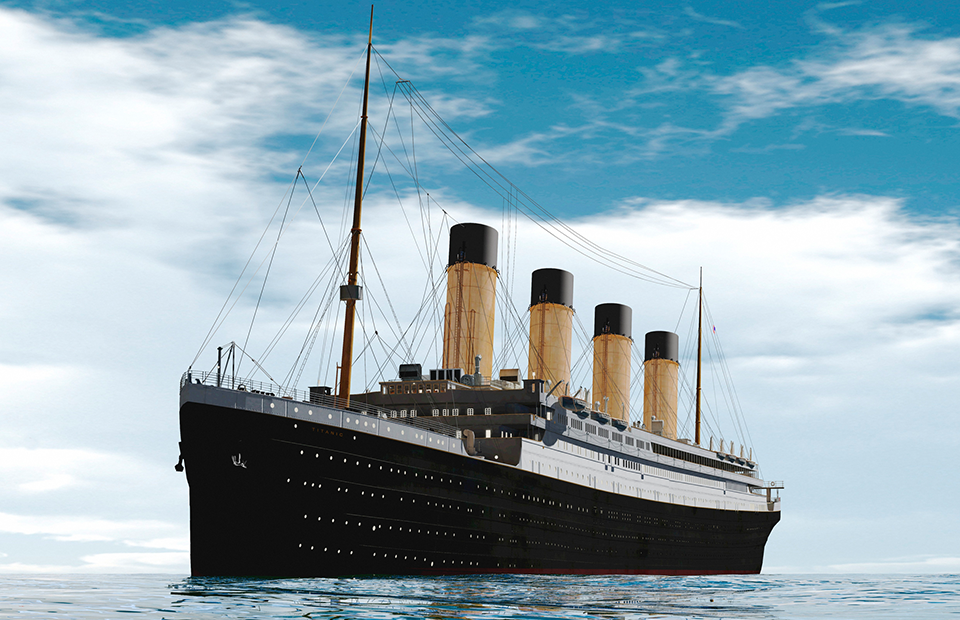

<i>Целью данного проекта является **исследование и моделирование факторов, влияющих на выживаемость пассажиров Титаника**, с использованием методов анализа данных и машинного обучения.</i>

📌 **Основная задача** — построить **предиктивную модель**, позволяющую предсказать, **выжил ли он в катастрофе** на основе характеристик пассажира (таких как:

- пол,  
- возраст,  
- класс билета и др.)

# Импортирование библиотек

In [299]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, precision_score, recall_score, f1_score, classification_report, confusion_matrix

from feature_engine import encoding as ce
from feature_engine import imputation as mdi
from feature_engine import discretisation as dsc

In [300]:
# Функции

# Загрузка датасета

In [301]:
data = pd.read_csv('../titanic.csv')
data.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


- `pclass` — Класс пассажира (1, 2 или 3), отражает социальный статус и уровень комфорта на борту.

- `survived` — Выжил ли пассажир (1 — выжил, 0 — не выжил).

- `name` — Имя пассажира.

- `sex` — Пол пассажира (мужчина или женщина).

- `age` — Возраст пассажира.

- `sibsp` — Количество братьев/сестер или супругов на борту.

- `parch` — Количество родителей или детей на борту.

- `ticket` — Номер билета.

- `fare` — Стоимость билета.

- `cabin` — Номер каюты, если пассажир был размещен в каюте.

- `embarked` — Порт посадки пассажира (C — Cherbourg, Q — Queenstown, S — Southampton).

- `boat` — Номер спасательной шлюпки, в которой пассажир оказался (если был спасен).

- `body` — Номер тела, если пассажир был найден после катастрофы.

- `home.dest` — Местоположение дома или конечный пункт назначения пассажира.

# Первичный анализ дасета

## Краткий анализ Датафрейма

In [302]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pclass     1309 non-null   int64  
 1   survived   1309 non-null   int64  
 2   name       1309 non-null   object 
 3   sex        1309 non-null   object 
 4   age        1046 non-null   float64
 5   sibsp      1309 non-null   int64  
 6   parch      1309 non-null   int64  
 7   ticket     1309 non-null   object 
 8   fare       1308 non-null   float64
 9   cabin      295 non-null    object 
 10  embarked   1307 non-null   object 
 11  boat       486 non-null    object 
 12  body       121 non-null    float64
 13  home.dest  745 non-null    object 
dtypes: float64(3), int64(4), object(7)
memory usage: 143.3+ KB


- **Размер датасета:** 1309 записей и 14 признаков.
- **Пропущенные значения:**
  - `age` — 263 пропуска → важный числовой признак, потребуется восстановление (например, медианой или на основе других признаков).
  - `fare` — всего 1 пропуск → можно просто заполнить медианой.
  - `cabin` — очень много пропусков (более 75%) → либо удалить, либо преобразовать в бинарный признак "есть/нет".
  - `embarked` — 2 пропуска → можно заполнить самым частым значением.
  - `boat`, `body`, `home.dest` — много пропусков, использовать с осторожностью или вовсе исключить.
- **Типы данных:**
  - `pclass`, `survived`, `sibsp`, `parch` — числовые, но отражают категориальную или булевую информацию.
  - `name`, `ticket`, `cabin`, `home.dest` — строковые признаки, потенциально можно извлечь дополнительные фичи (например, титул из `name`).
  - `sex`, `embarked` — категориальные, потребуют кодирования (например, one-hot).
- **Целевая переменная:** `survived` — бинарная (0/1), подходит для задач классификации.

**Вывод:**  
Перед началом анализа потребуется очистка данных: обработка пропусков, кодирование категорий, а также, возможно, удаление или преобразование некоторых столбцов.


## Статистический анализ числовых колонок

In [303]:
data.describe()

,pclass,survived,age,sibsp,parch,fare,body
count,1309.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000,121.000000
mean,2.294882,0.381971,29.881135,0.498854,0.385027,33.295479,160.809917
std,0.837836,0.486055,14.413500,1.041658,0.865560,51.758668,97.696922
min,1.000000,0.000000,0.166700,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,21.000000,0.000000,0.000000,7.895800,72.000000
50%,3.000000,0.000000,28.000000,0.000000,0.000000,14.454200,155.000000
75%,3.000000,1.000000,39.000000,1.000000,0.000000,31.275000,256.000000
max,3.000000,1.000000,80.000000,8.000000,9.000000,512.329200,328.000000


- Возраст пассажиров варьируется от младенцев до пожилых людей, с средней возрастной группой около 30 лет.

- 38% пассажиров выжили, что соответствует историческим данным о катастрофе.

- Большинство пассажиров путешествовали в одиночку.

- Стоимость билета имеет широкий диапазон, что указывает на разный социальный статус пассажиров.

- В столбце `body` много пропущенных данных, что делает его менее полезным для анализа.

Следует провести обработку пропущенных значений, особенно в столбце `age`, для дальнейшего анализа.

# Анализ на наличие пустых значений

In [304]:
data.isnull().mean()

pclass       0.000000
survived     0.000000
name         0.000000
sex          0.000000
age          0.200917
sibsp        0.000000
parch        0.000000
ticket       0.000000
fare         0.000764
cabin        0.774637
embarked     0.001528
boat         0.628724
body         0.907563
home.dest    0.430863
dtype: float64

- Столбцы с нулевыми пропусками: `pclass`, `survived`, `name`, `sex`, `sibsp`, `parch`, `ticket`, `fare`, `embarked`.

- Столбец age имеет 0.2% пропусков, что можно заполнить средним значением или использовать другие методы.

- `cabin` имеет 77.5% пропусков и может быть исключен из анализа или обработан с помощью категориальных методов.

- `boat` и `body` имеют высокий процент пропусков (62.9% и 90.8% соответственно), что делает их менее полезными.

- `home.dest` имеет 43.1% пропусков, требует дополнительного анализа.

**Рекомендуется обработать пропущенные значения, особенно в столбцах с небольшим процентом пропусков, а в столбцах с большим количеством пропусков (например, `cabin` и `body`) — принять решение об исключении или альтернативной обработке.**

## Типы переменных

In [305]:
discrete = [var for var in data.columns if data[var].dtype != 'O' and var != 'survived' and data[var].nunique() < 10]
continuous = [var for var in data.columns if data[var].dtype != 'O' and var != 'survived' and var not in discrete]

mixed = ['cabin']
categorical = [var for var in data.columns if data[var].dtype == 'O' and var not in mixed]

print(f"There are {len(discrete)} descrete variables")
print(f"There are {len(continuous)} continuous variables")
print(f"There are {len(categorical)} categorical variables")
print(f"There are {len(mixed)} mixed variables")

There are 3 descrete variables
There are 3 continuous variables
There are 6 categorical variables
There are 1 mixed variables


In [306]:
discrete

['pclass', 'sibsp', 'parch']

In [307]:
continuous

['age', 'fare', 'body']

In [308]:
categorical

['name', 'sex', 'ticket', 'embarked', 'boat', 'home.dest']

In [309]:
mixed

['cabin']

# Визуализация и иследовательский анализ данных

## BoxPlot по дискретным признакам

<Axes: >

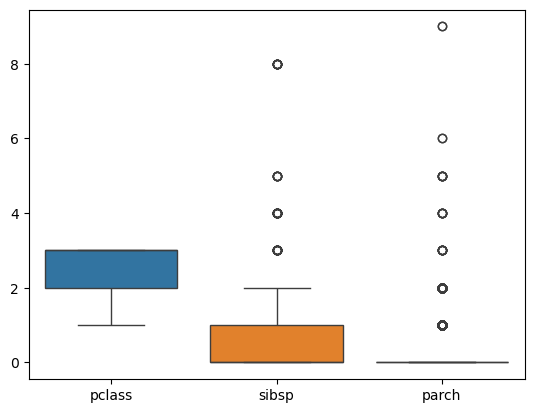

In [310]:
discrete = ['pclass', 'sibsp', 'parch']
sns.boxplot(data[discrete])

**Боксплоты по дискретным признакам позволяют выявить выбросы и распределение категориальных признаков. Например, переменные `sibsp`, `parch` могут иметь аномальные значения.**

## BoxPlot по непрерывным признакам

<Axes: >

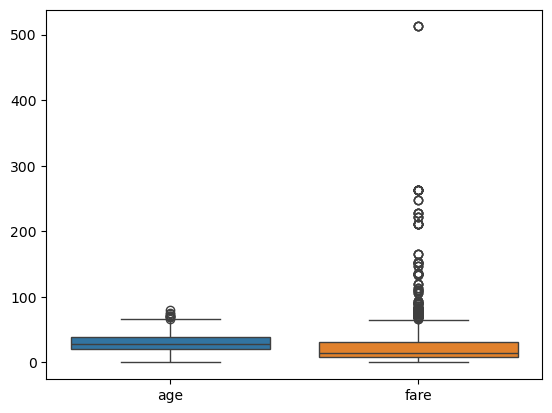

In [311]:
continuous = ['age', 'fare']
sns.boxplot(data[continuous])

**Boxplot по `fare` и `age` показывает выбросы, особенно в `fare`, что может потребовать нормализации или логарифмирования.**

## Гистограммы

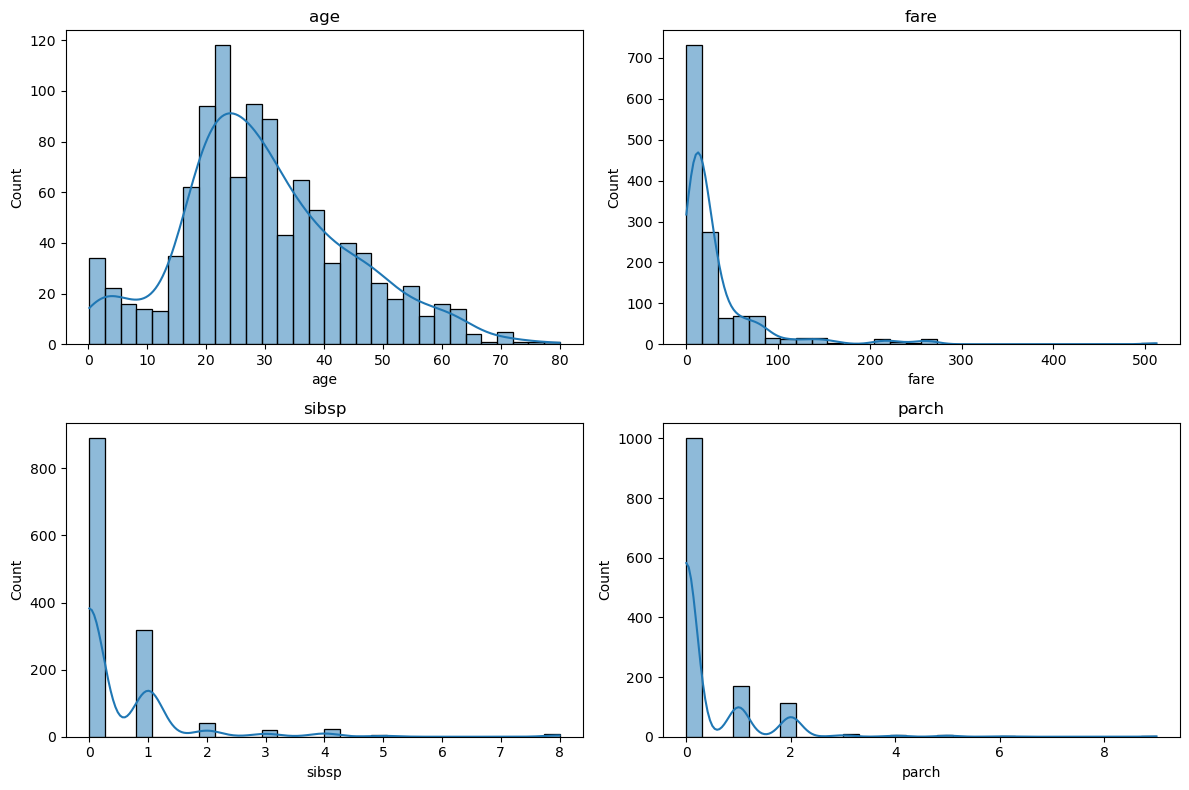

In [312]:
num_features = ['age', 'fare', 'sibsp', 'parch']

plt.figure(figsize = (12, 8))
for idx, feature in enumerate(num_features, 1):
    plt.subplot(2, 2, idx)
    sns.histplot(data[feature], kde = True, bins = 30)
    plt.title(f"{feature}")
plt.tight_layout()
plt.show()

- `age` : возраст распределен с пиковой концентрацией вокруг 20-40 лет, с небольшим числом очень молодых и старых пассажиров.

- `fare` : стоимость билетов имеет широкий диапазон, с пиком в более низком диапазоне, но с несколькими высокими значениями.

- `sibsp` : большинство пассажиров путешествовали без братьев/сестер или супругов, с небольшим количеством людей, путешествующих с несколькими родственниками.

- `parch` : большинство пассажиров не имели детей или родителей, с несколькими людьми, путешествующими с семьей.

**Гистограммы показывают, что распределения переменных имеют различную форму и ширину. Явные пики в гистограмме или отдельные столбцы, сильно отличающиеся от основной массы данных, могут указывать на выбросы или необычные значения.**

# Barplot

## Pclass & Survived

In [313]:
data.pclass.value_counts()

pclass
3    709
1    323
2    277
Name: count, dtype: int64

In [314]:
data[['pclass', 'survived']].groupby(['pclass'], as_index = False).sum()

,pclass,survived
0,1,200
1,2,119
2,3,181


<Axes: xlabel='pclass', ylabel='survived'>

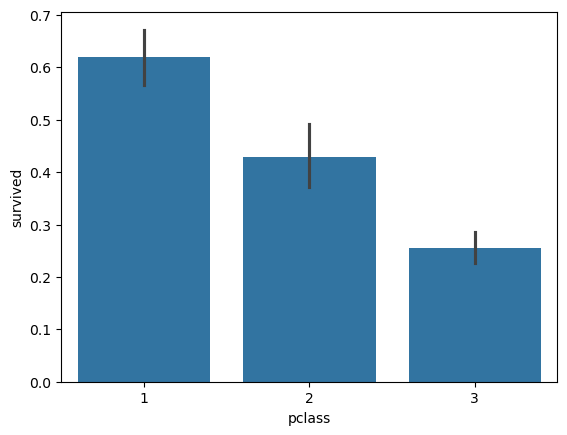

In [315]:
sns.barplot(data = data, x = "pclass", y = "survived")

### В данном наблюдени мы видим, что в процентном соотношении наибольшая выживаемость в первом классе 

## Sex & Survived

In [316]:
data.sex.value_counts()

sex
male      843
female    466
Name: count, dtype: int64

In [317]:
data[['sex', 'survived']].groupby(['sex'], as_index = False).sum()

,sex,survived
0,female,339
1,male,161


<Axes: xlabel='sex', ylabel='survived'>

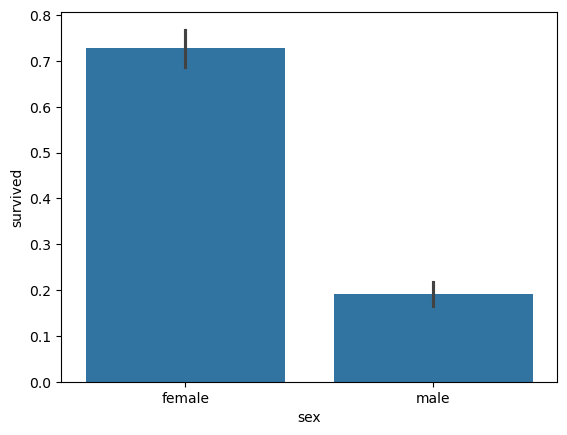

In [318]:
sns.barplot(x = 'sex', y = 'survived', data = data)

### В данном наблюдении мы наглядно видим, что у женщин высокая выживаемость 

# Age & Survived

In [319]:
data.age.value_counts()

age
24.0000    47
22.0000    43
21.0000    41
30.0000    40
18.0000    39
25.0000    34
28.0000    32
36.0000    31
26.0000    30
29.0000    30
27.0000    30
19.0000    29
23.0000    26
32.0000    24
31.0000    23
35.0000    23
20.0000    23
45.0000    21
33.0000    21
39.0000    20
17.0000    20
16.0000    19
42.0000    18
40.0000    18
34.0000    16
50.0000    15
38.0000    14
48.0000    14
47.0000    14
2.0000     12
41.0000    11
44.0000    10
54.0000    10
1.0000     10
9.0000     10
4.0000     10
43.0000     9
37.0000     9
49.0000     9
51.0000     8
14.0000     8
55.0000     8
60.0000     7
3.0000      7
15.0000     6
46.0000     6
8.0000      6
6.0000      6
52.0000     6
58.0000     6
62.0000     5
57.0000     5
61.0000     5
5.0000      5
13.0000     5
64.0000     5
11.0000     4
53.0000     4
10.0000     4
32.5000     4
7.0000      4
56.0000     4
63.0000     4
0.7500      3
18.5000     3
59.0000     3
28.5000     3
65.0000     3
40.5000     3
12.0000     3
0.8333      3
34

In [320]:
data['age'].isnull().mean()

np.float64(0.20091673032849502)

In [321]:
data[['age', 'survived']].groupby(['age'], as_index = False).sum()

,age,survived
0,0.1667,1
1,0.3333,0
2,0.4167,1
3,0.6667,1
4,0.7500,2
5,0.8333,3
6,0.9167,2
7,1.0000,7
8,2.0000,4
9,3.0000,5


In [322]:
data['age_group'] = pd.cut(data['age'], 4)
print(data[['age_group', 'survived']].groupby(['age_group'], as_index = False, observed = False).mean())

          age_group  survived
0  (0.0869, 20.125]  0.459677
1  (20.125, 40.083]  0.390543
2  (40.083, 60.042]  0.422680
3    (60.042, 80.0]  0.242424


<Axes: xlabel='age_group', ylabel='survived'>

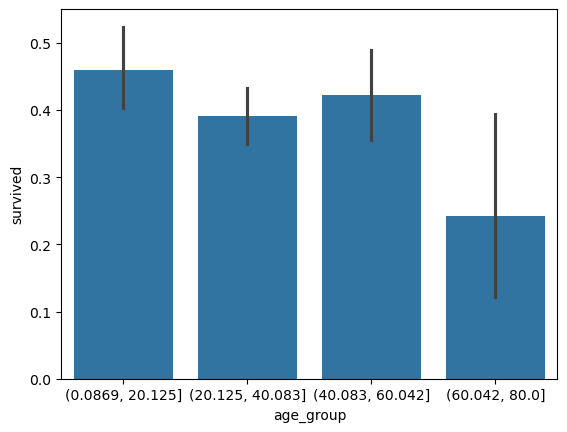

In [323]:
sns.barplot(x = 'age_group', y = 'survived', data = data)

In [324]:
data['age'].isnull().mean()

np.float64(0.20091673032849502)

### В данном наблюдении можно сделать вывод, что выживали в основном люди до пожилого возраста.В основном это дети и мы предполагаем, что люди которые были в составе семьи или супругов.

# SibSp, Parch & Survived

In [325]:
data.sibsp.value_counts()

sibsp
0    891
1    319
2     42
4     22
3     20
8      9
5      6
Name: count, dtype: int64

In [326]:
data[['sibsp', 'survived']].groupby(['sibsp'], as_index = False).sum()

,sibsp,survived
0,0,309
1,1,163
2,2,19
3,3,6
4,4,3
5,5,0
6,8,0


<Axes: xlabel='sibsp', ylabel='survived'>

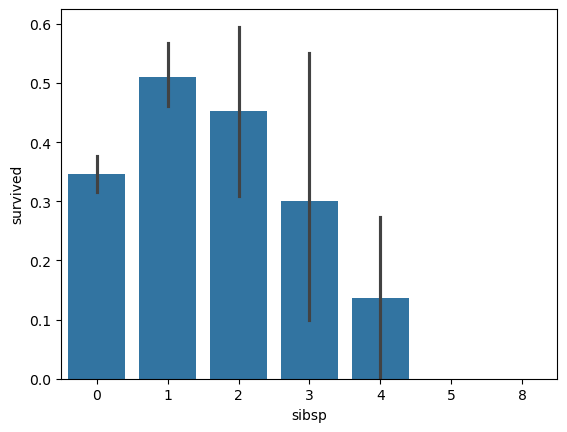

In [327]:
sns.barplot(x = 'sibsp', y = 'survived', data = data)

In [328]:
data.parch.value_counts()

parch
0    1002
1     170
2     113
3       8
4       6
5       6
6       2
9       2
Name: count, dtype: int64

In [329]:
data[['parch', 'survived']].groupby(['parch'], as_index = False).sum()

,parch,survived
0,0,336
1,1,100
2,2,57
3,3,5
4,4,1
5,5,1
6,6,0
7,9,0


<Axes: xlabel='parch', ylabel='survived'>

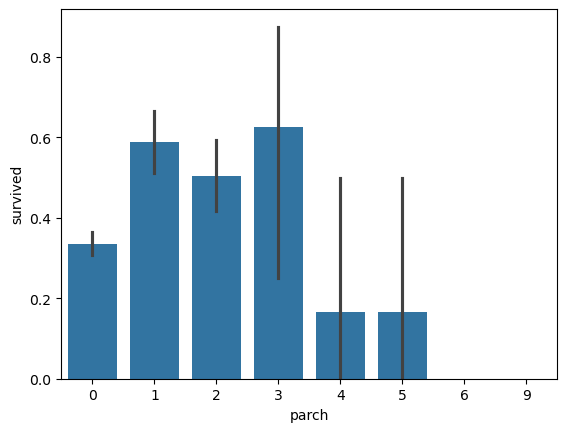

In [330]:
sns.barplot(x = 'parch', y = 'survived', data = data)

### В данном наблюдении мы видим, что у человека была высокая вероятность выживания при наличии на борту от 1-3 родственников, но более низкая, если у человека было больше 3 родственников или же если он вовсе путешествовал в одиночку (за исключением некоторых случаев с 4 и более родственниками).

# Embarked & Survived

In [331]:
data.embarked.value_counts()

embarked
S    914
C    270
Q    123
Name: count, dtype: int64

In [332]:
data[['embarked', 'survived']].groupby(['embarked'], as_index = False).sum()

,embarked,survived
0,C,150
1,Q,44
2,S,304


<Axes: xlabel='embarked', ylabel='survived'>

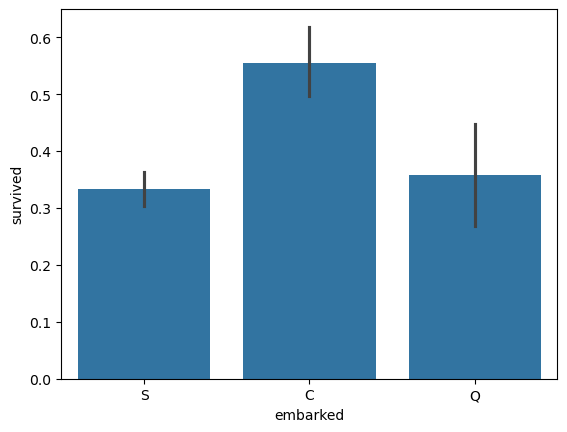

In [333]:
sns.barplot(x = 'embarked', y = 'survived', data = data)

### Исходя из данного наблюдения, можно отметить, что поссажиры севшие на борт в порту `C` и `Q` имели больший шанс на выживаение, нежели пассажиры севшие на борт в порту `S`

# Cabin & Survived

In [334]:
data.cabin.value_counts().head()

cabin
F      8
C23    6
B57    5
G6     5
C22    4
Name: count, dtype: int64

In [335]:
data['cabin_tmp'] = data['cabin'].str.extract('([A-Za-z]+)')
data['cabin_tmp'].head()

0    B
1    C
2    C
3    C
4    C
Name: cabin_tmp, dtype: object

In [336]:
data.fillna({'cabin_tmp': 'nan'}, inplace=True)
data['cabin_tmp'].unique()

array(['B', 'C', 'E', 'D', 'A', 'nan', 'T', 'F', 'G'], dtype=object)

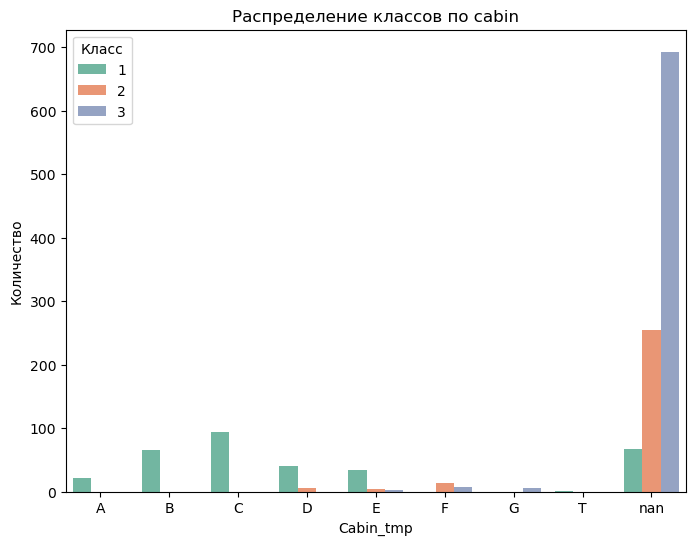

In [337]:
plt.figure(figsize=(8, 6))

order = sorted(data['cabin_tmp'].unique())
sns.countplot(data=data, x='cabin_tmp', hue='pclass', palette='Set2', order=order)

plt.title("Распределение классов по cabin")
plt.xlabel("Cabin_tmp")
plt.ylabel("Количество")
plt.legend(title="Класс")
plt.show()

### В данном наблюдении мы видим, что номер каюты был в основном у людей которые находились в 1 классе, а у пассажиров 2 и 3 класса номер каюты был не известен.

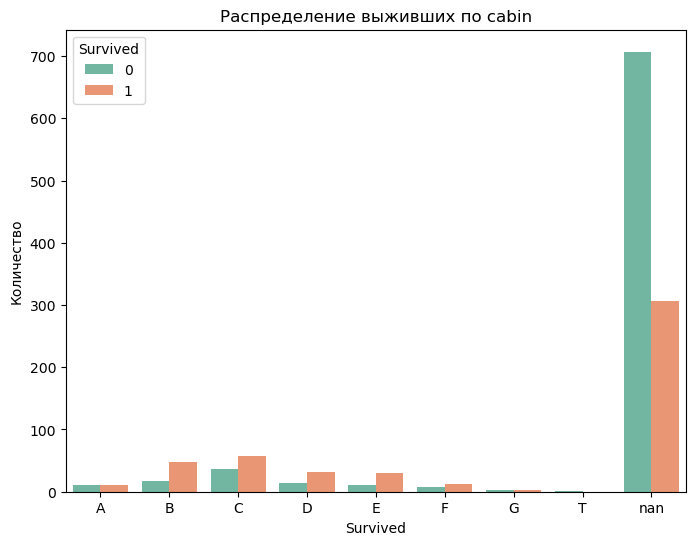

In [338]:
plt.figure(figsize=(8, 6))
order = sorted(data['cabin_tmp'].unique())
sns.countplot(data=data, x='cabin_tmp', hue='survived', palette='Set2', order=order)

plt.title("Распределение выживших по cabin")
plt.xlabel("Survived")
plt.ylabel("Количество")
plt.legend(title="Survived")
plt.show()

In [339]:
data['cabin_known'] = data['cabin'].notnull().astype(int)

In [340]:
data['cabin_tmp'] = data['cabin_tmp'].replace({
    'A': 'ABC', 
    'B': 'ABC',
    'C': 'ABC',
    'D': 'DE',
    'E': 'DE',
    'F': 'FG',
    'G': 'FG',
    'T': 'nan'
})

data.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest,age_group,cabin_tmp,cabin_known
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO","(20.125, 40.083]",ABC,1
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22,S,11,NaN,"Montreal, PQ / Chesterville, ON","(0.0869, 20.125]",ABC,1
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22,S,NaN,NaN,"Montreal, PQ / Chesterville, ON","(0.0869, 20.125]",ABC,1
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22,S,NaN,135.0,"Montreal, PQ / Chesterville, ON","(20.125, 40.083]",ABC,1
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22,S,NaN,NaN,"Montreal, PQ / Chesterville, ON","(20.125, 40.083]",ABC,1


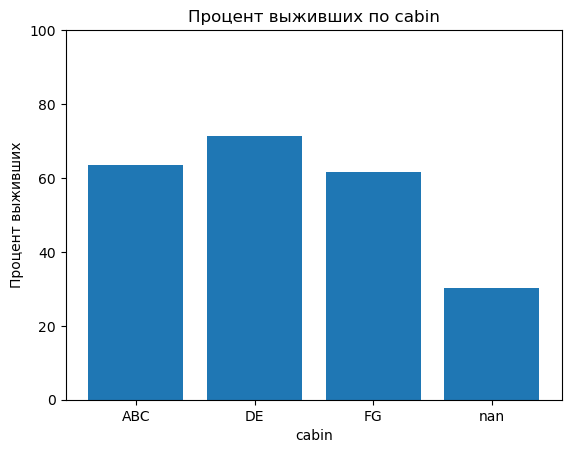

In [341]:
survival_by_letter = data.groupby('cabin_tmp')['survived'].mean().sort_index() * 100

plt.bar(survival_by_letter.index, survival_by_letter.values)
plt.xlabel('cabin')
plt.ylabel('Процент выживших')
plt.title('Процент выживших по cabin')
plt.ylim(0, 100) 
plt.show()

### Исходя из двух наблюдений, можно заметить, что так или иначе наличие номера каюты немного но влияло на шанс выживания.

# Fare & Survived

In [342]:
data[['fare', 'survived']].groupby(['fare'], as_index = False).sum()

,fare,survived
0,0.0000,2
1,3.1708,1
2,4.0125,0
3,5.0000,0
4,6.2375,0
5,6.4375,0
6,6.4500,0
7,6.4958,0
8,6.7500,0
9,6.8583,0


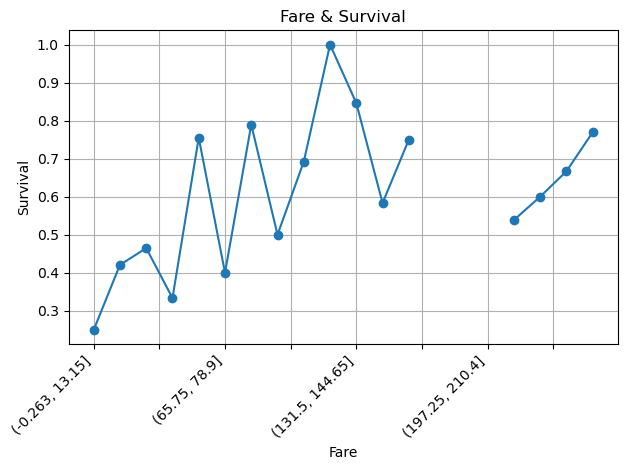

In [343]:
data = data[data['fare'] < 300].copy()
data['fare_bin'] = pd.cut(data['fare'], bins=20)

fare_survival = data.groupby('fare_bin', observed=False)['survived'].mean()

fare_survival.plot(kind='line', marker='o')
plt.xticks(rotation=45, ha='right')
plt.title('Fare & Survival')
plt.xlabel('Fare')
plt.ylabel('Survival')
plt.grid()
plt.tight_layout()
plt.show()

### Данное наблюдение построено на цене билета за каюту, а не за одного человека, попробуем вывести примерную цену билет на 1 человека и сделать дальнейшие выводы.

In [344]:
data['family_size'] = data['sibsp'] + data['parch'] + 1
data['alone'] = (data['sibsp'] + data['parch']) == 0

In [345]:
data['fare_per_prsn'] = data['fare'] / data['family_size']
data.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,...,boat,body,home.dest,age_group,cabin_tmp,cabin_known,fare_bin,family_size,alone,fare_per_prsn
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,...,2,NaN,"St Louis, MO","(20.125, 40.083]",ABC,1,"(210.4, 223.55]",1,True,211.3375
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22,...,11,NaN,"Montreal, PQ / Chesterville, ON","(0.0869, 20.125]",ABC,1,"(144.65, 157.8]",4,False,37.8875
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22,...,NaN,NaN,"Montreal, PQ / Chesterville, ON","(0.0869, 20.125]",ABC,1,"(144.65, 157.8]",4,False,37.8875
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22,...,NaN,135.0,"Montreal, PQ / Chesterville, ON","(20.125, 40.083]",ABC,1,"(144.65, 157.8]",4,False,37.8875
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22,...,NaN,NaN,"Montreal, PQ / Chesterville, ON","(20.125, 40.083]",ABC,1,"(144.65, 157.8]",4,False,37.8875


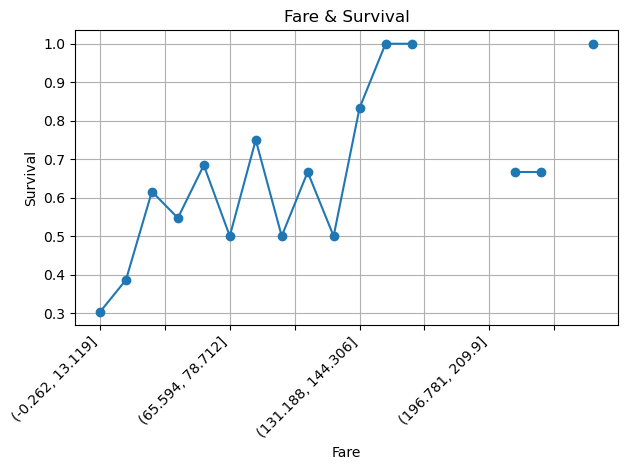

In [346]:
data = data[data['fare_per_prsn'] < 300].copy()
data['fare_bin'] = pd.cut(data['fare_per_prsn'], bins=20)

fare_survival = data.groupby('fare_bin', observed=False)['survived'].mean()

fare_survival.plot(kind='line', marker='o')
plt.xticks(rotation=45, ha='right')
plt.title('Fare & Survival')
plt.xlabel('Fare')
plt.ylabel('Survival')
plt.grid()
plt.tight_layout()
plt.show()

### Исходя из данных наблюдений, можно предположить, что всё же более высокая цена на билет давала больше шансов на выживание.

# Name & Survived

In [347]:
data.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,...,boat,body,home.dest,age_group,cabin_tmp,cabin_known,fare_bin,family_size,alone,fare_per_prsn
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,...,2,NaN,"St Louis, MO","(20.125, 40.083]",ABC,1,"(209.9, 223.019]",1,True,211.3375
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22,...,11,NaN,"Montreal, PQ / Chesterville, ON","(0.0869, 20.125]",ABC,1,"(26.238, 39.356]",4,False,37.8875
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22,...,NaN,NaN,"Montreal, PQ / Chesterville, ON","(0.0869, 20.125]",ABC,1,"(26.238, 39.356]",4,False,37.8875
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22,...,NaN,135.0,"Montreal, PQ / Chesterville, ON","(20.125, 40.083]",ABC,1,"(26.238, 39.356]",4,False,37.8875
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22,...,NaN,NaN,"Montreal, PQ / Chesterville, ON","(20.125, 40.083]",ABC,1,"(26.238, 39.356]",4,False,37.8875


In [348]:
data['title'] = data['name'].str.extract(' ([A-Za-z]+)\.')

In [349]:
pd.crosstab(data['title'], data['sex'])

sex,female,male
title,,
Capt,0,1
Col,0,4
Countess,1,0
Don,0,1
Dona,1,0
Dr,1,7
Jonkheer,0,1
Lady,1,0
Major,0,2


In [350]:
data['title'] = data['title'].replace(['Lady', 'Countess','Capt', 'Col', \
     'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Other')
data['title'] = data['title'].replace('Mlle', 'Miss')
data['title'] = data['title'].replace('Ms', 'Miss')
data['title'] = data['title'].replace('Mme', 'Mrs')
    
data[['title', 'survived']].groupby(['title'], as_index=False).sum()

,title,survived
0,Master,31
1,Miss,178
2,Mr,121
3,Mrs,155
4,Other,11


### В данном наблюдении можно сделать вывод, что данная переменная тесно взаимосвязанна с переменной `Sex`, так как вывод из наблюдения данной переменной можно сделать только один, что так или иначе всё сводится к тому, что женщины выживали больше чем мужчины, вне зависимости от положения в обществе. Поэтому, данную переменную можно не использовать для прогнозирования в наших моделях, ведь она прямопропорциональна переменной `Sex`.

# Survived

In [351]:
data['survived'].info()

<class 'pandas.core.series.Series'>
Index: 1304 entries, 0 to 1308
Series name: survived
Non-Null Count  Dtype
--------------  -----
1304 non-null   int64
dtypes: int64(1)
memory usage: 20.4 KB


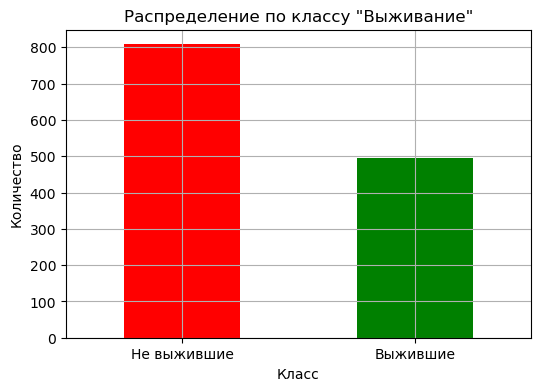

In [352]:
plt.figure(figsize=(6, 4))
data['survived'].value_counts().plot(kind='bar', color=['red', 'green'])
plt.title('Распределение по классу "Выживание"')
plt.xlabel('Класс')
plt.ylabel('Количество')
plt.xticks([0, 1], ['Не выжившие', 'Выжившие'], rotation=0)
plt.grid(True)
plt.show()

`survived` - Из данного наблюдения вывод получили простой, количество выживших меньше.

# *Вывод из проведённого анализа по переменным по отношению к нашему таргету:*
- `name`  : Данная переменная прямопропорциональна к переменной `sex`, в следствии чего, её можно сбросить.
- `home.dest`  : Не даёт нам особо ничего, кроме понимания откуда и куда напрявлялся пассажир. Её тоже можно не использовать для нашего проекта.
- `body` , `boat`  : В данных переменных очень большое количество пустых значений. Поэтому их проще сбросить, чем как либо апперировать с ними.
- `ticket`  : Малоинформативный, неструктурированный и шумный признак. Не имеет логически обоснованной связи с шансом на выживание. Надлежит сбросу.
- `pclass`  : Переменная которая однозначно имеет большую связь с шансом на выживание.
- `sex`  : Переменная с наибольшей взаимосвязью с шансом на выживание.
- `parch` , `sibsp`  : Переменные которые тоже имею не плохую взаимосвязь с шансом на выживание.
- `cabin`  : Переменная в которой много пустых значений, но не смотря на это с ней можно попробовать поработать, так как прослеживается связь с таргетом.
- `age`  : Переменная с небольшим количеством пустых значений, с ней можно поработать. Связь с нашим таргетом имеется.
- `embarked`  : В данной переменной отслеживается связь с нашим таргетом.
- `fare`  : В данной переменной тоже отслеживается взаимосвязь с нашим таргетом.

# Предобработка данных

### Разаделение на тренировочный и тестовый сет

In [353]:
cols = [
    'pclass',
    'survived',
    'sex',
    'age',
    'cabin_known',
    'fare_per_prsn',
    'alone',
    'embarked'
]

data = data[cols]

In [354]:
data.head()

,pclass,survived,sex,age,cabin_known,fare_per_prsn,alone,embarked
0,1,1,female,29.0000,1,211.3375,True,S
1,1,1,male,0.9167,1,37.8875,False,S
2,1,0,female,2.0000,1,37.8875,False,S
3,1,0,male,30.0000,1,37.8875,False,S
4,1,0,female,25.0000,1,37.8875,False,S


# Построение PipeLine

In [355]:
data.isnull().mean()

pclass           0.000000
survived         0.000000
sex              0.000000
age              0.201687
cabin_known      0.000000
fare_per_prsn    0.000000
alone            0.000000
embarked         0.001534
dtype: float64

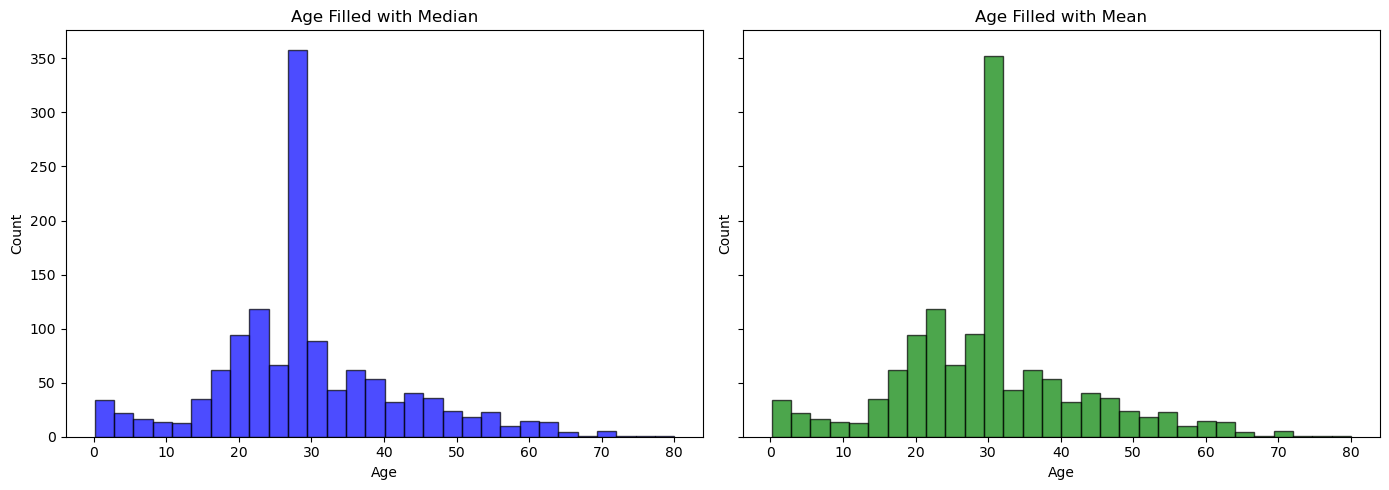

In [356]:
ages_median = data['age'].fillna(data['age'].median())
ages_mean = data['age'].fillna(data['age'].mean())

# Построение гистограмм
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# Медиана
axes[0].hist(ages_median, bins=30, color='blue', edgecolor='black', alpha=0.7)
axes[0].set_title('Age Filled with Median')
axes[0].set_xlabel('Age')
axes[0].set_ylabel('Count')

# Среднее
axes[1].hist(ages_mean, bins=30, color='green', edgecolor='black', alpha=0.7)
axes[1].set_title('Age Filled with Mean')
axes[1].set_xlabel('Age')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

- `age` - Исходя из наблюдений по данной переменной, нет особой разницы в том, какой использовать метод для замнены пустых значений.
- `embarked` - В данной переменной просто заменили на `mode` , так как процент пустых значений очень мал, поэтому было принято решение использовать     этот метод замены пустых значений.

In [357]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1304 entries, 0 to 1308
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   pclass         1304 non-null   int64  
 1   survived       1304 non-null   int64  
 2   sex            1304 non-null   object 
 3   age            1041 non-null   float64
 4   cabin_known    1304 non-null   int64  
 5   fare_per_prsn  1304 non-null   float64
 6   alone          1304 non-null   bool   
 7   embarked       1302 non-null   object 
dtypes: bool(1), float64(2), int64(3), object(2)
memory usage: 82.8+ KB


### Разделение на тренировочный и тестовый сет

In [358]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop('survived', axis=1),
    data['survived'],
    test_size = 0.3,
    random_state = 0
)

### PipeLine

Тренируем Logistic Regression...
Logistic Regression: Accuracy = 0.8036, Precision = 0.7313, Recall = 0.7050, F1 = 0.7179, ROC AUC = 0.8013
Тренируем Random Forest...
Random Forest: Accuracy = 0.8087, Precision = 0.7222, Recall = 0.7482, F1 = 0.7350, ROC AUC = 0.8254
Тренируем SVC...
SVC: Accuracy = 0.8036, Precision = 0.7313, Recall = 0.7050, F1 = 0.7179, ROC AUC = 0.8076
Тренируем KNN...
KNN: Accuracy = 0.7959, Precision = 0.7323, Recall = 0.6691, F1 = 0.6992, ROC AUC = 0.8292
Тренируем Decision Tree...
Decision Tree: Accuracy = 0.8010, Precision = 0.7194, Recall = 0.7194, F1 = 0.7194, ROC AUC = 0.8040
Тренируем Gradient Boosting...
Gradient Boosting: Accuracy = 0.8087, Precision = 0.7319, Recall = 0.7266, F1 = 0.7292, ROC AUC = 0.8231
Тренируем XGBoost...
XGBoost: Accuracy = 0.8061, Precision = 0.7234, Recall = 0.7338, F1 = 0.7286, ROC AUC = 0.8251
Тренируем Naive Bayes...
Naive Bayes: Accuracy = 0.7959, Precision = 0.7007, Recall = 0.7410, F1 = 0.7203, ROC AUC = 0.8112


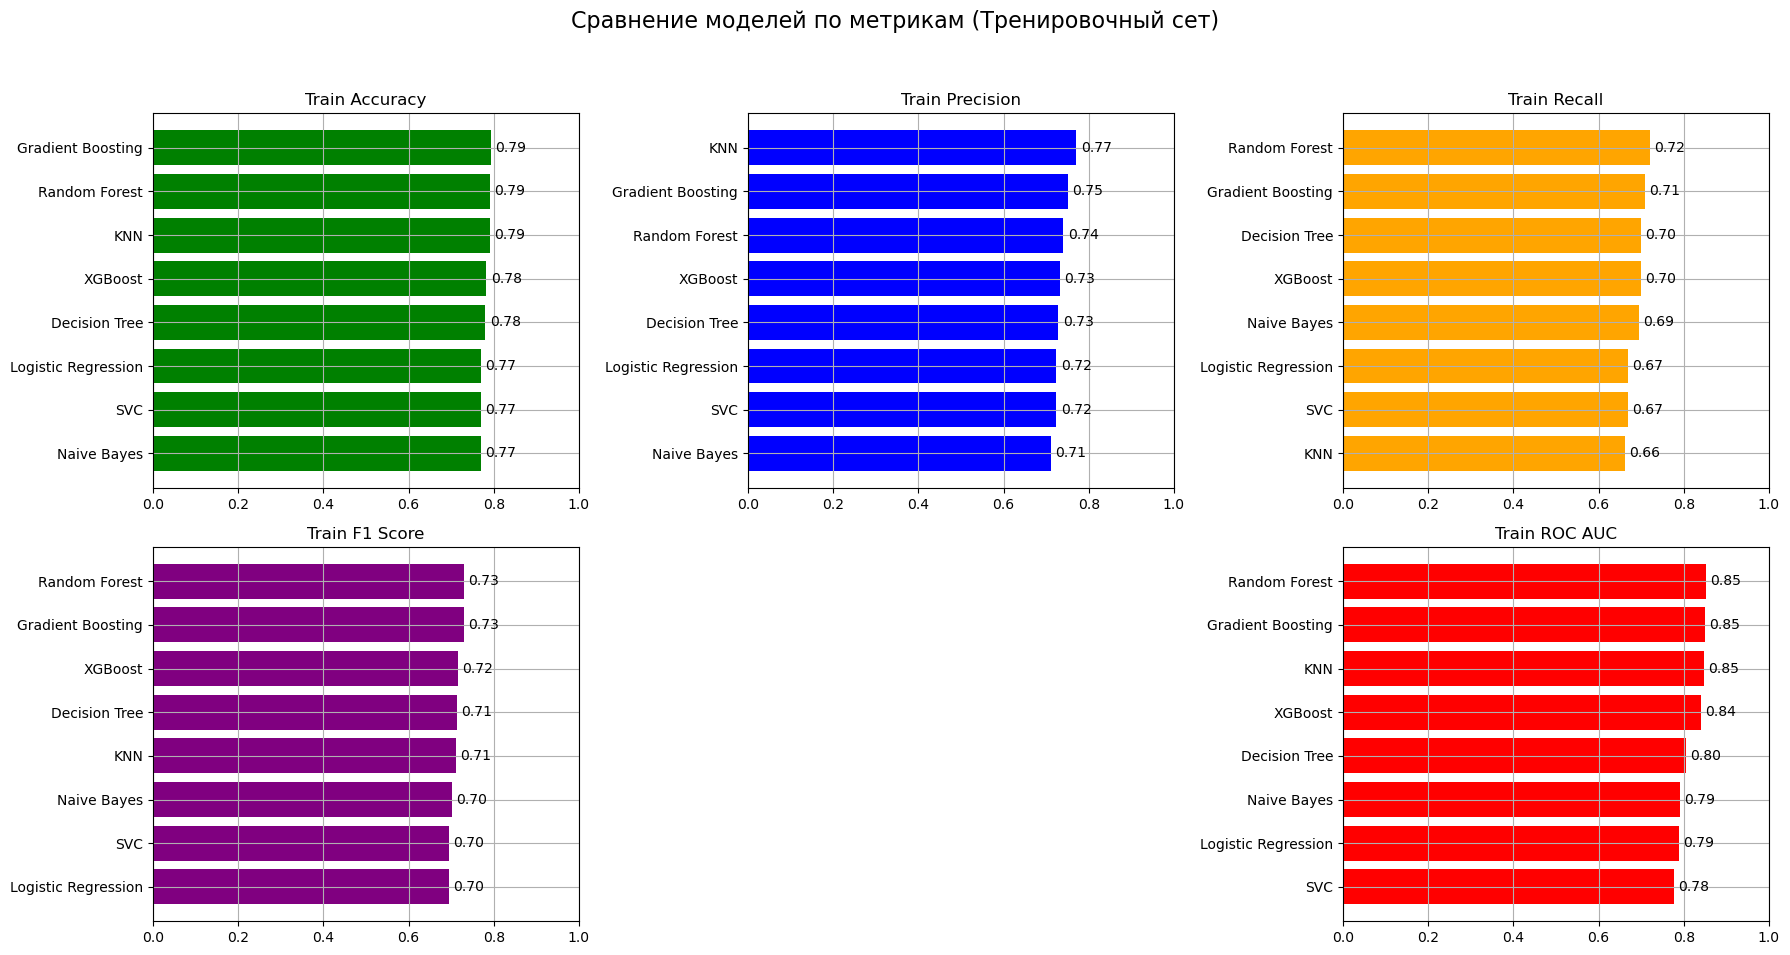


 Лучшая модель на тренировочном сете: Gradient Boosting
Accuracy: 0.794, Precision: 0.751, Recall: 0.709, F1 Score: 0.729, ROC AUC: 0.850


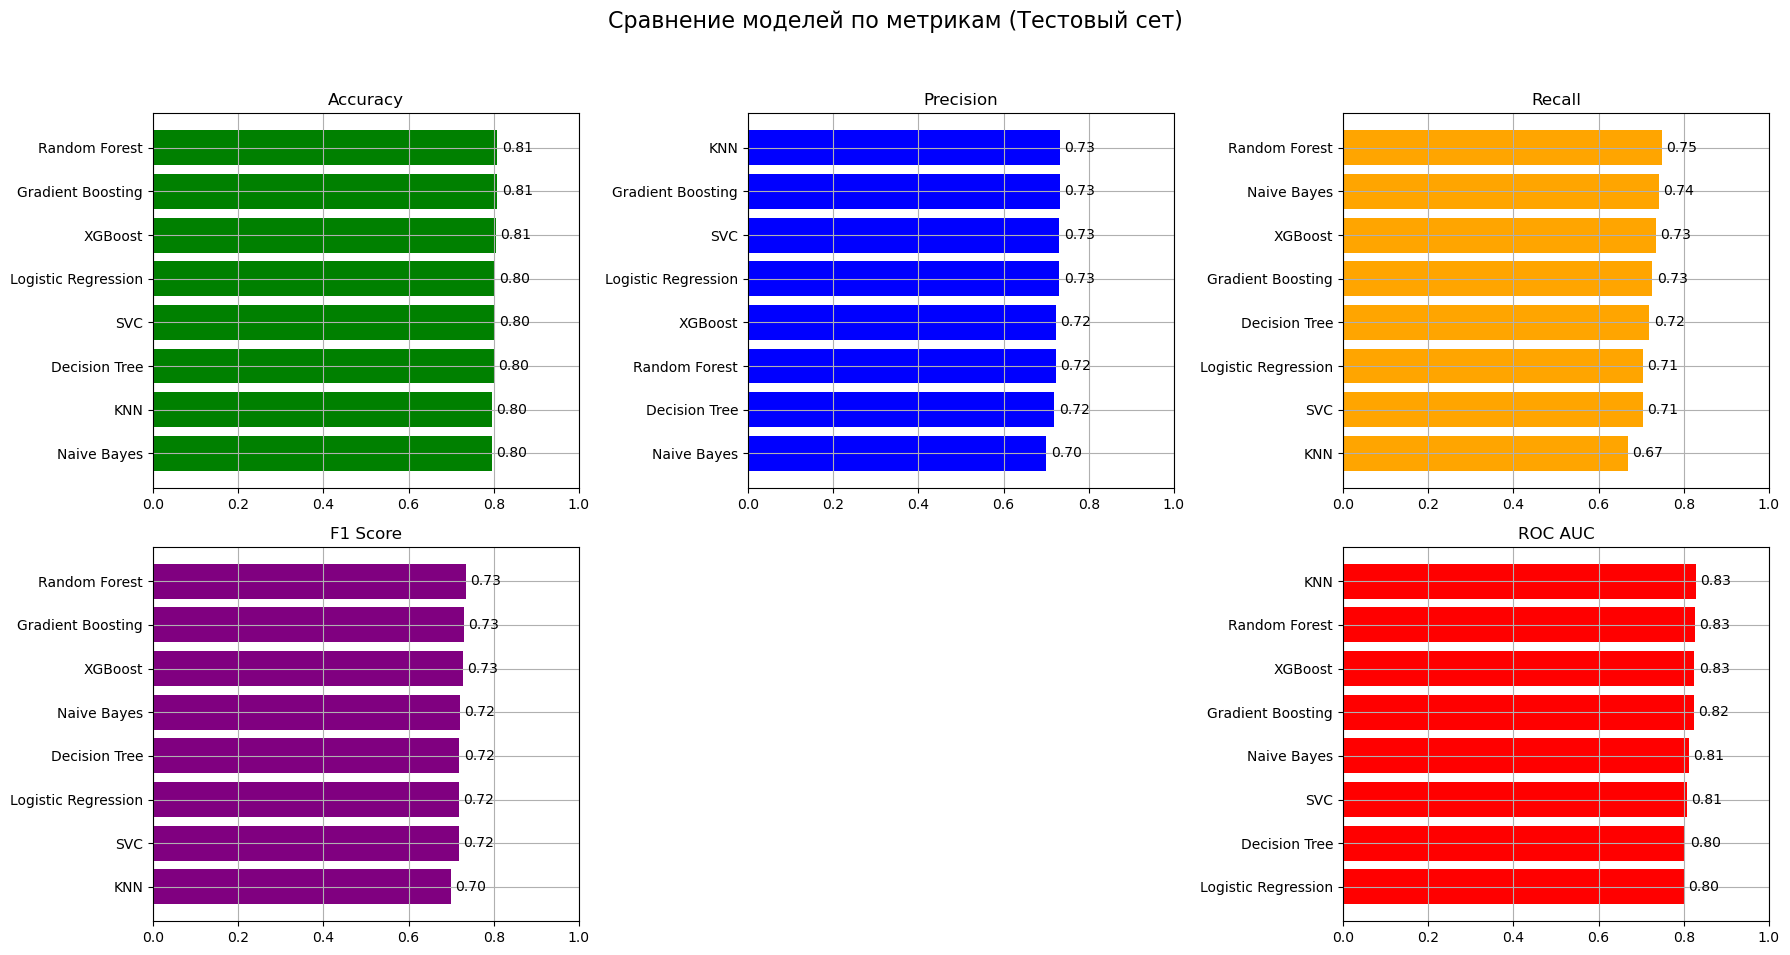


 Лучшая модель: Random Forest
Accuracy: 0.809, Precision: 0.722, Recall: 0.748, F1 Score: 0.735, ROC AUC: 0.825
Гиперпараметры: {'classifier__max_depth': 5, 'classifier__n_estimators': 100}


In [360]:
# Преобразование для числовых и категориальных признаков
numeric_features = ['age']
categorical_features = ['sex', 'alone', 'embarked']

# Пайплайн для числовых признаков
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  
    ('scaler', StandardScaler())                 
])

# Пайплайн для категориальных признаков
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

# Объединение трансформеров в ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Словарь с моделями
models = {
    'Logistic Regression': Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(random_state=0))
    ]),
    'Random Forest': Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(random_state=0))
    ]),
    'SVC': Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', SVC(probability=True, random_state=0))
    ]),
    'KNN': Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', KNeighborsClassifier())
    ]),
    'Decision Tree': Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', DecisionTreeClassifier(random_state=0))
    ]),
    'Gradient Boosting': Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', GradientBoostingClassifier(random_state=0))
    ]),
    'XGBoost': Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', XGBClassifier(eval_metric='logloss', random_state=0))
    ]),
    'Naive Bayes': Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', GaussianNB())
    ])
}

# Параметры для GridSearchCV
param_grids = {
    'Logistic Regression': {
        'classifier__C': [0.1, 1, 10],
        'classifier__penalty': ['l2'],
        'classifier__solver': ['lbfgs']
    },
    'Random Forest': {
        'classifier__n_estimators': [50, 100],
        'classifier__max_depth': [5, 10]
    },
    'SVC': {
        'classifier__C': [0.1, 1, 10],
        'classifier__gamma': [0.01, 0.1, 1]
    },
    'KNN': {
        'classifier__n_neighbors': [3, 5, 7],
        'classifier__weights': ['uniform', 'distance']
    },
    'Decision Tree': {
        'classifier__max_depth': [3, 5, 10],
        'classifier__min_samples_split': [2, 5]
    },
    'Gradient Boosting': {
        'classifier__n_estimators': [50, 100],
        'classifier__learning_rate': [0.01, 0.1],
        'classifier__max_depth': [3, 5]
    },
    'XGBoost': {
        'classifier__n_estimators': [50, 100],
        'classifier__learning_rate': [0.01, 0.1],
        'classifier__max_depth': [3, 5]
    },
    'Naive Bayes': {}
}

best_models = {}
results = []

cv = KFold(n_splits=5, shuffle=True, random_state=0)

for name, pipeline in models.items():
    print(f'Тренируем {name}...')
    grid = GridSearchCV(pipeline, param_grids.get(name, {}), cv=cv, n_jobs=-1)
    grid.fit(X_train, y_train)
    best_models[name] = grid.best_estimator_
    y_pred = grid.predict(X_test)
    
    # Расчёт метрик
    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, grid.predict_proba(X_test)[:, 1])

    results.append((name, acc, precision, recall, f1, roc_auc, grid.best_params_))
    print(f'{name}: Accuracy = {acc:.4f}, Precision = {precision:.4f}, Recall = {recall:.4f}, F1 = {f1:.4f}, ROC AUC = {roc_auc:.4f}')

# Для Тренировочного сета
# Сортировка от большего к меньшему
sorted_idx_acc_train = np.argsort(-train_accuracies)
sorted_idx_prec_train = np.argsort(-train_precisions)
sorted_idx_rec_train = np.argsort(-train_recalls)
sorted_idx_f1_train = np.argsort(-train_f1_scores)
sorted_idx_roc_train = np.argsort(-train_roc_aucs)

# Отрисовка графиков
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

# Accuracy
axes[0].barh(train_model_names[sorted_idx_acc_train], train_accuracies[sorted_idx_acc_train], color='green')
axes[0].set_title('Train Accuracy')
for i, v in enumerate(train_accuracies[sorted_idx_acc_train]):
    axes[0].text(v + 0.01, i, f"{v:.2f}", va='center')

# Precision
axes[1].barh(train_model_names[sorted_idx_prec_train], train_precisions[sorted_idx_prec_train], color='blue')
axes[1].set_title('Train Precision')
for i, v in enumerate(train_precisions[sorted_idx_prec_train]):
    axes[1].text(v + 0.01, i, f"{v:.2f}", va='center')

# Recall
axes[2].barh(train_model_names[sorted_idx_rec_train], train_recalls[sorted_idx_rec_train], color='orange')
axes[2].set_title('Train Recall')
for i, v in enumerate(train_recalls[sorted_idx_rec_train]):
    axes[2].text(v + 0.01, i, f"{v:.2f}", va='center')

# F1 Score
axes[3].barh(train_model_names[sorted_idx_f1_train], train_f1_scores[sorted_idx_f1_train], color='purple')
axes[3].set_title('Train F1 Score')
for i, v in enumerate(train_f1_scores[sorted_idx_f1_train]):
    axes[3].text(v + 0.01, i, f"{v:.2f}", va='center')

# Удаляем лишнюю ось
fig.delaxes(axes[4])

# ROC-AUC
axes[5].barh(train_model_names[sorted_idx_roc_train], train_roc_aucs[sorted_idx_roc_train], color='red')
axes[5].set_title('Train ROC AUC')
for i, v in enumerate(train_roc_aucs[sorted_idx_roc_train]):
    axes[5].text(v + 0.01, i, f"{v:.2f}", va='center')

# Настройки осей
for ax in [axes[i] for i in [0, 1, 2, 3, 5]]:
    ax.set_xlim(0, 1)
    ax.invert_yaxis()
    ax.grid(True)

# Заголовок
plt.suptitle("Сравнение моделей по метрикам (Тренировочный сет)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Выводим лучшие результаты
best_train_idx = np.argmax(train_accuracies)
best_train_model_name = train_results[best_train_idx][0]

print(f"\n Лучшая модель на тренировочном сете: {best_train_model_name}")
print(f"Accuracy: {train_results[best_train_idx][1]:.3f}, Precision: {train_results[best_train_idx][2]:.3f}, "
      f"Recall: {train_results[best_train_idx][3]:.3f}, F1 Score: {train_results[best_train_idx][4]:.3f}, "
      f"ROC AUC: {train_results[best_train_idx][5]:.3f}")

# Для Тестового сета
accuracies = np.array(accuracies)
precisions = np.array(precisions)
recalls = np.array(recalls)
f1_scores = np.array(f1_scores)
roc_aucs = np.array(roc_aucs)
model_names = np.array(model_names)

# Сортировка от большего к меньшему
sorted_idx_acc = np.argsort(-accuracies)
sorted_idx_prec = np.argsort(-precisions)
sorted_idx_rec = np.argsort(-recalls)
sorted_idx_f1 = np.argsort(-f1_scores)
sorted_idx_roc = np.argsort(-roc_aucs)

# Отрисовка графиков
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

# Accuracy
axes[0].barh(model_names[sorted_idx_acc], accuracies[sorted_idx_acc], color='green')
axes[0].set_title('Accuracy')
for i, v in enumerate(accuracies[sorted_idx_acc]):
    axes[0].text(v + 0.01, i, f"{v:.2f}", va='center')

# Precision
axes[1].barh(model_names[sorted_idx_prec], precisions[sorted_idx_prec], color='blue')
axes[1].set_title('Precision')
for i, v in enumerate(precisions[sorted_idx_prec]):
    axes[1].text(v + 0.01, i, f"{v:.2f}", va='center')

# Recall
axes[2].barh(model_names[sorted_idx_rec], recalls[sorted_idx_rec], color='orange')
axes[2].set_title('Recall')
for i, v in enumerate(recalls[sorted_idx_rec]):
    axes[2].text(v + 0.01, i, f"{v:.2f}", va='center')

# F1 Score
axes[3].barh(model_names[sorted_idx_f1], f1_scores[sorted_idx_f1], color='purple')
axes[3].set_title('F1 Score')
for i, v in enumerate(f1_scores[sorted_idx_f1]):
    axes[3].text(v + 0.01, i, f"{v:.2f}", va='center')

# Удаляем лишнюю ось
fig.delaxes(axes[4])

# ROC-AUC
axes[5].barh(model_names[sorted_idx_roc], roc_aucs[sorted_idx_roc], color='red')
axes[5].set_title('ROC AUC')
for i, v in enumerate(roc_aucs[sorted_idx_roc]):
    axes[5].text(v + 0.01, i, f"{v:.2f}", va='center')

for ax in [axes[i] for i in [0, 1, 2, 3, 5]]:
    ax.set_xlim(0, 1)
    ax.invert_yaxis()
    ax.grid(True)

plt.suptitle("Сравнение моделей по метрикам (Тестовый сет)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


# Выводим лучшие результаты
best_idx = np.argmax(accuracies)
best_model_name, best_acc, best_precision, best_recall, best_f1, best_roc_auc, best_params = results[best_idx]

print(f"\n Лучшая модель: {best_model_name}")
print(f"Accuracy: {best_acc:.3f}, Precision: {best_precision:.3f}, Recall: {best_recall:.3f}, F1 Score: {best_f1:.3f}, ROC AUC: {best_roc_auc:.3f}")
print(f"Гиперпараметры: {best_params}")

- *Переобучение моделей не наблюдается. По итогу лучшая модель для прогнозирования вышла `Random Forest`*

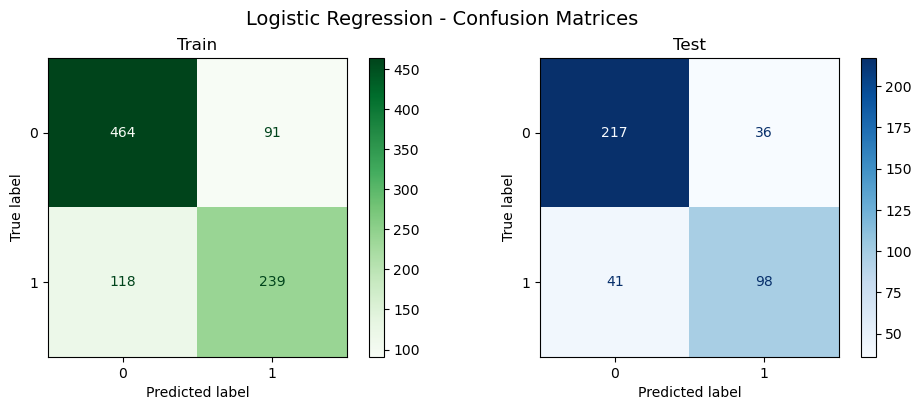

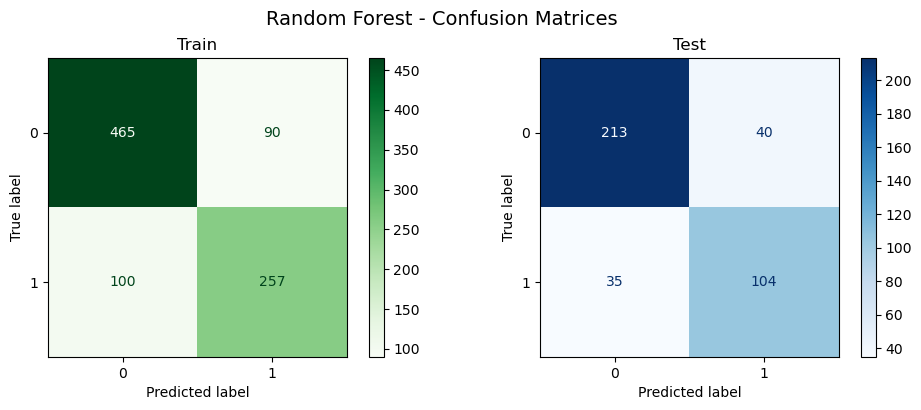

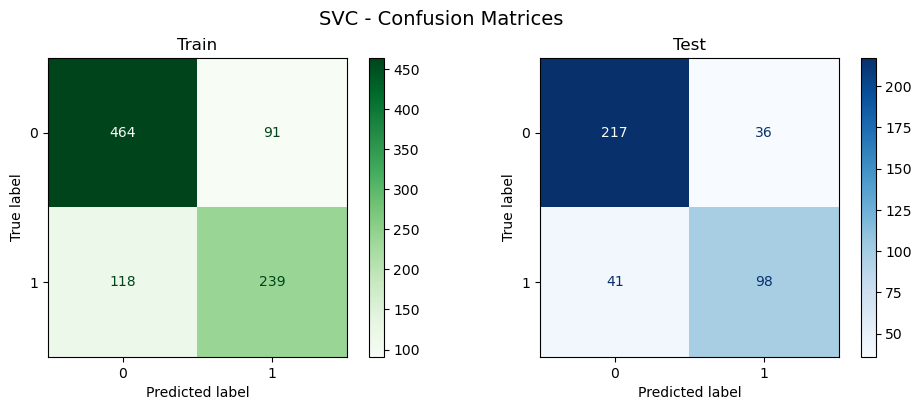

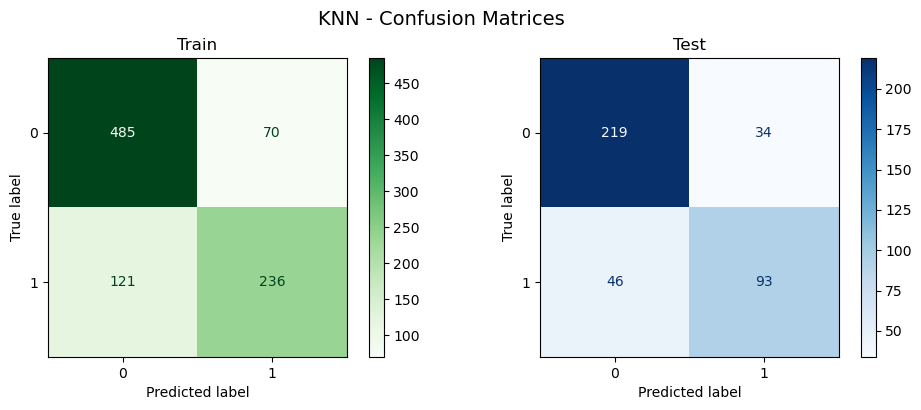

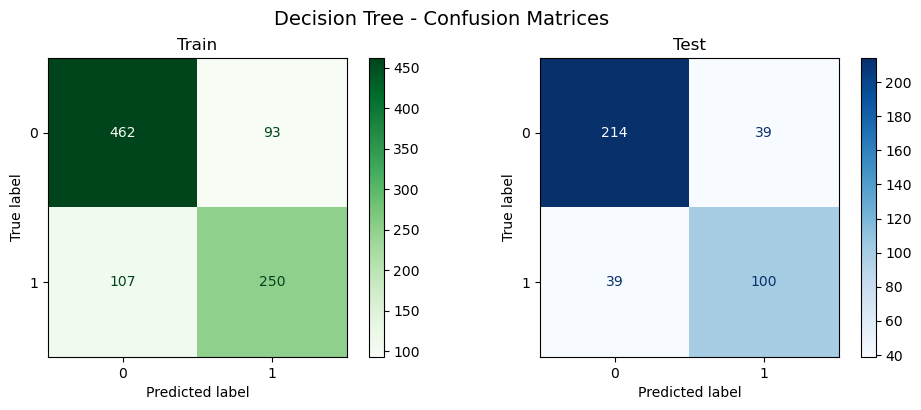

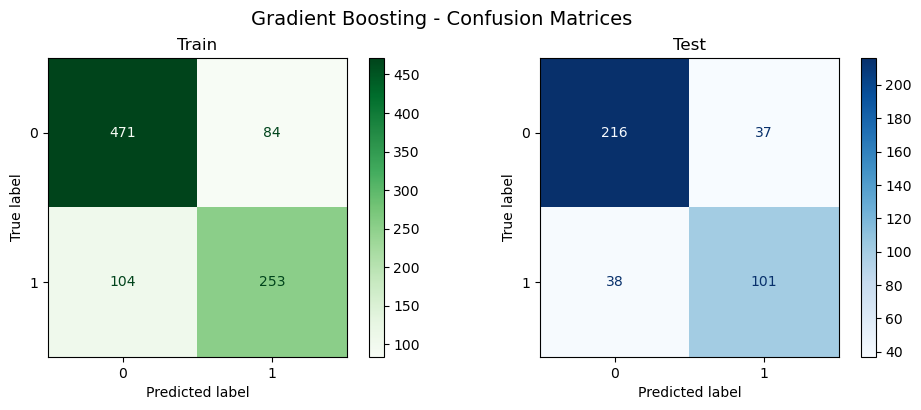

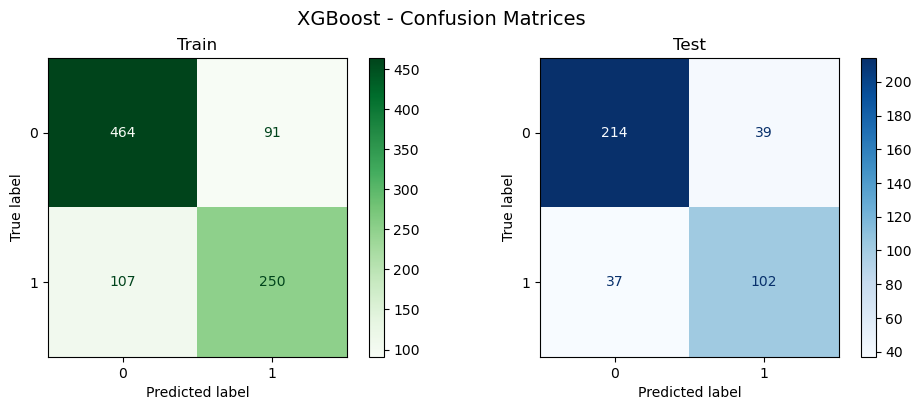

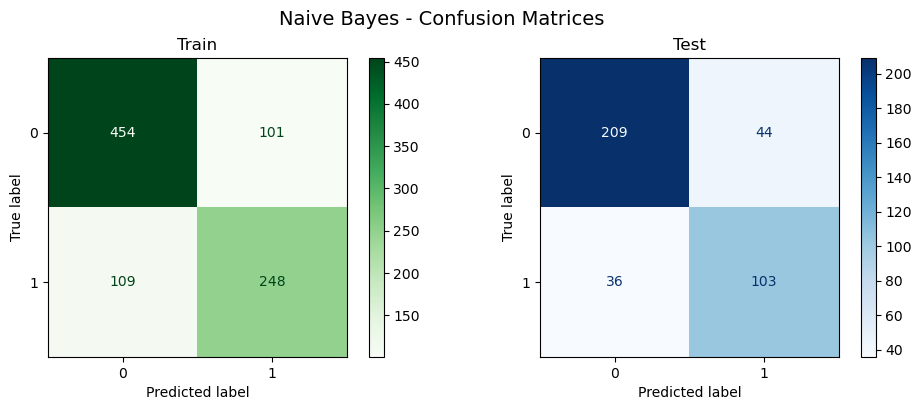

In [361]:
for name, model in best_models.items():
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    fig.suptitle(f'{name} - Confusion Matrices', fontsize=14)

    # Train
    y_train_pred = model.predict(X_train)
    ConfusionMatrixDisplay.from_predictions(
        y_train, y_train_pred, ax=axes[0], cmap='Greens'
    )
    axes[0].set_title("Train")

    # Test
    y_test_pred = model.predict(X_test)
    ConfusionMatrixDisplay.from_predictions(
        y_test, y_test_pred, ax=axes[1], cmap='Blues'
    )
    axes[1].set_title("Test")

    plt.tight_layout()
    plt.show()

In [362]:
# Список для сбора всех метрик
report_rows = []

# Перебираем модели
for name, model in best_models.items():
    # Предсказания
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Получаем classification_report в виде словаря
    train_report = classification_report(y_train, y_train_pred, output_dict=True)
    test_report = classification_report(y_test, y_test_pred, output_dict=True)

    # Для каждого основного класса и 'weighted avg'
    for label in ['0', '1', 'weighted avg']:
        row = {
            'Model': name,
            'Class': label,
            'Train Precision': train_report[label]['precision'],
            'Train Recall': train_report[label]['recall'],
            'Train F1-Score': train_report[label]['f1-score'],
            'Test Precision': test_report[label]['precision'],
            'Test Recall': test_report[label]['recall'],
            'Test F1-Score': test_report[label]['f1-score'],
        }
        report_rows.append(row)

# Создаём DataFrame и выводим таблицу
report_df = pd.DataFrame(report_rows)
pd.set_option("display.max_rows", None)
display(report_df.round(3))

,Model,Class,Train Precision,Train Recall,Train F1-Score,Test Precision,Test Recall,Test F1-Score
0,Logistic Regression,0,0.797,0.836,0.816,0.841,0.858,0.849
1,Logistic Regression,1,0.724,0.669,0.696,0.731,0.705,0.718
2,Logistic Regression,weighted avg,0.769,0.771,0.769,0.802,0.804,0.803
3,Random Forest,0,0.823,0.838,0.830,0.859,0.842,0.850
4,Random Forest,1,0.741,0.720,0.730,0.722,0.748,0.735
5,Random Forest,weighted avg,0.791,0.792,0.791,0.810,0.809,0.809
6,SVC,0,0.797,0.836,0.816,0.841,0.858,0.849
7,SVC,1,0.724,0.669,0.696,0.731,0.705,0.718
8,SVC,weighted avg,0.769,0.771,0.769,0.802,0.804,0.803
9,KNN,0,0.800,0.874,0.835,0.826,0.866,0.846
